In [1]:
!pip install "dask[complete]"
!pip install pyarrow pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [2]:
!pip install scikit-fuzzy
!pip install fuzzy-c-means

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.5
    Uninstalling typer-0.12.5:
      Successfully uninstalled typer-0.12.5


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import dask.dataframe as dd
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import numpy as np
import skfuzzy as fuzz

from warnings import filterwarnings
filterwarnings('ignore')

In [5]:

# Directory containing the data files
data_dir = '/content/drive/MyDrive/Data_hasking'

# Get a list of all parquet files for the 10 days
file_list = sorted(glob.glob(f"{data_dir}/*.parquet"))[:20]  # Adjust the slicing if needed

# Load all parquet files into a Dask DataFrame
ddf = dd.read_parquet(file_list)

# Compute the DataFrame to get a Pandas DataFrame
df = ddf.compute()

In [6]:

# Load customer data
tb_customers = dd.read_parquet('/content/drive/MyDrive/TB_CUSTOMERS.parquet')
tb_customers_df = tb_customers.compute()

In [7]:
# Filter for individual customers
tb_customers_individual_df = tb_customers_df[tb_customers_df["CUSTOMER_TYPE"] == "Cá nhân"]
individual_customers = tb_customers_individual_df["CUST_CUSTNO"].unique().tolist()

In [8]:
# Filter transactions for individual customers
df_individual = df[df['CUST_CUSTNO'].isin(individual_customers)]

In [9]:
# Convert VALUEDATE to datetime
df_individual['VALUEDATE'] = pd.to_datetime(df_individual['VALUEDATE'], errors='coerce')

In [10]:

# Extract date only from VALUEDATE
df_individual['DATE_ONLY'] = df_individual['VALUEDATE'].dt.date


In [11]:
# Separate deposits (receipts) and withdrawals
df_deposits = df_individual[df_individual['AMOUNT'] > 0]
df_withdrawals = df_individual[df_individual['AMOUNT'] < 0]

In [12]:
# Aggregate amounts by customer and date
daily_deposits = df_deposits.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_deposits')
daily_withdrawals = df_withdrawals.groupby(['CUST_CUSTNO', 'DATE_ONLY'])['AMOUNT'].sum().reset_index(name='total_withdrawals')

In [13]:
# Merge deposits and withdrawals
transactions = pd.merge(daily_deposits, daily_withdrawals, on=['CUST_CUSTNO', 'DATE_ONLY'], how='outer')

In [14]:
# Fill missing values with 0
transactions['total_deposits'].fillna(0, inplace=True)
transactions['total_withdrawals'].fillna(0, inplace=True)


In [15]:
# Log transform the total deposits and total withdrawals
transactions['log_total_deposits'] = np.log1p(transactions['total_deposits'])
transactions['log_total_withdrawals'] = np.log1p(transactions['total_withdrawals'].abs())

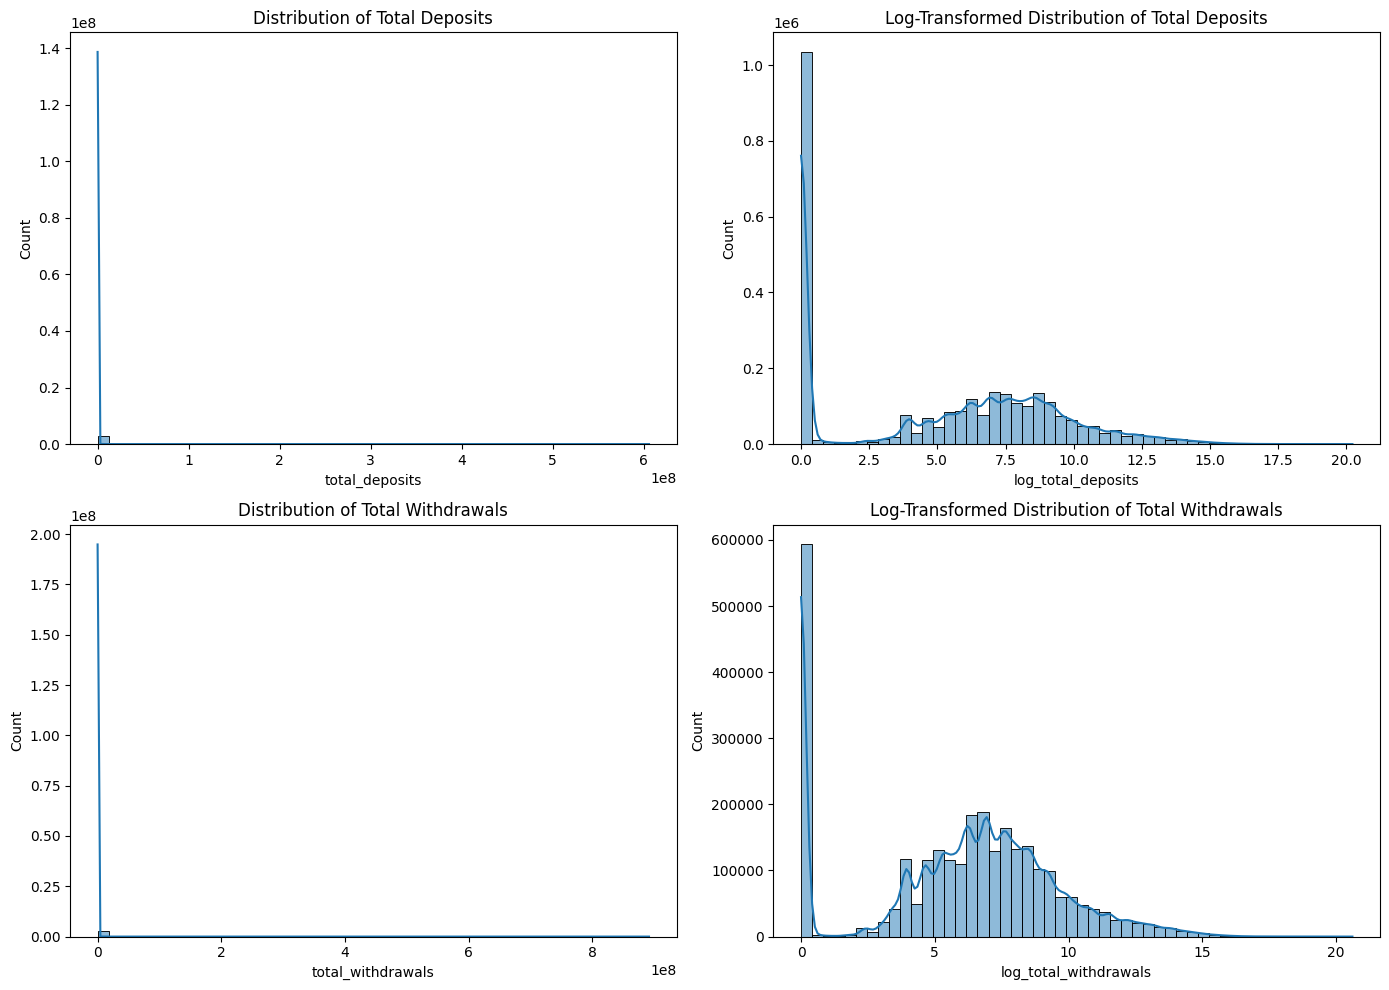

In [ ]:
# Plot the distributions before and after log transformation
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(transactions['total_deposits'], bins=50, kde=True, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Total Deposits')

sns.histplot(transactions['log_total_deposits'], bins=50, kde=True, ax=ax[0, 1])
ax[0, 1].set_title('Log-Transformed Distribution of Total Deposits')

sns.histplot(transactions['total_withdrawals'].abs(), bins=50, kde=True, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Total Withdrawals')

sns.histplot(transactions['log_total_withdrawals'], bins=50, kde=True, ax=ax[1, 1])
ax[1, 1].set_title('Log-Transformed Distribution of Total Withdrawals')

plt.tight_layout()
plt.show()

In [16]:
# Prepare the data for clustering
features = transactions[['log_total_deposits', 'log_total_withdrawals']].values

In [17]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

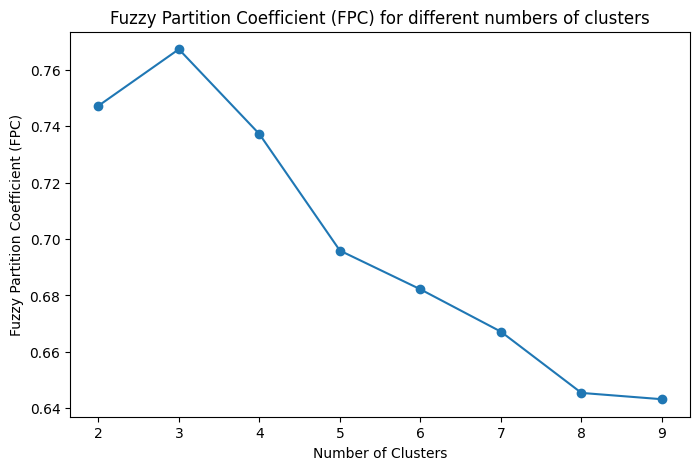

In [ ]:
# Define the range of clusters to evaluate
n_clusters_range = range(2, 10)
fpc_values = []

for n_clusters in n_clusters_range:
    # Apply Fuzzy C-Means clustering
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        features_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

    # Store the FPC value for this number of clusters
    fpc_values.append(fpc)

# Plot FPC values to visualize the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(n_clusters_range, fpc_values, marker='o')
plt.title('Fuzzy Partition Coefficient (FPC) for different numbers of clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Fuzzy Partition Coefficient (FPC)')
plt.show()

In [18]:
# Set the number of clusters
n_clusters = 3

In [19]:
# Apply Fuzzy C-Means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    features_scaled.T, c=n_clusters, m=2, error=0.005, maxiter=1000, init=None)

In [20]:
# Assign clusters to each transaction based on the highest membership
cluster_labels = np.argmax(u, axis=0)

In [21]:
# Add the cluster labels to the DataFrame
transactions['cluster'] = cluster_labels

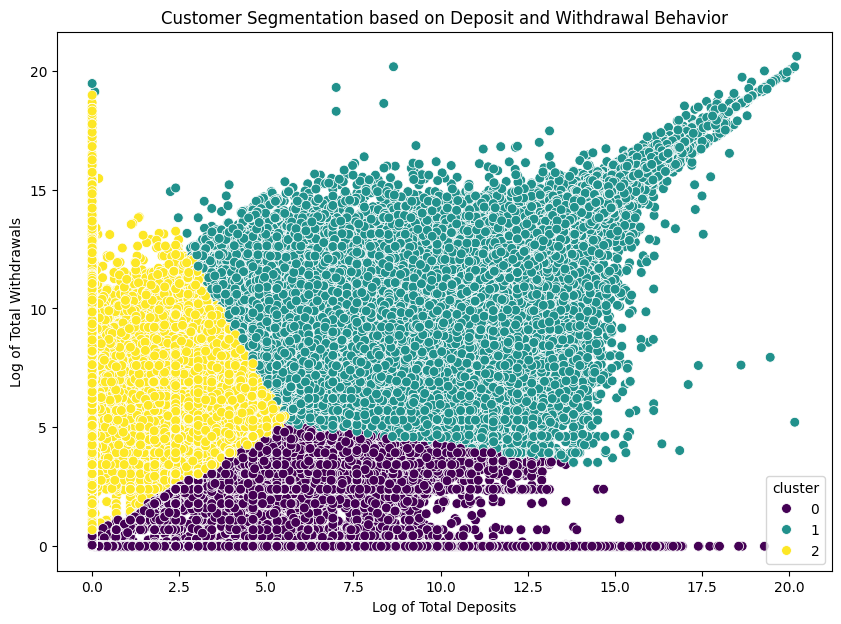

In [ ]:
# Visualize the distribution of transactions in each cluster
plt.figure(figsize=(10, 7))
sns.scatterplot(x='log_total_deposits', y='log_total_withdrawals', hue='cluster', data=transactions, palette='viridis', s=50)
plt.title('Customer Segmentation based on Deposit and Withdrawal Behavior')
plt.xlabel('Log of Total Deposits')
plt.ylabel('Log of Total Withdrawals')
plt.show()


In [23]:
# Count the number of transactions in each cluster
transactions['cluster'].value_counts()

,count
cluster,
0,1158257
1,1035153
2,654371


In [24]:
# Calculate suspicion scores based on distance from the cluster centroid
suspicion_scores = np.min(d, axis=0)
transactions['suspicion_score'] = suspicion_scores

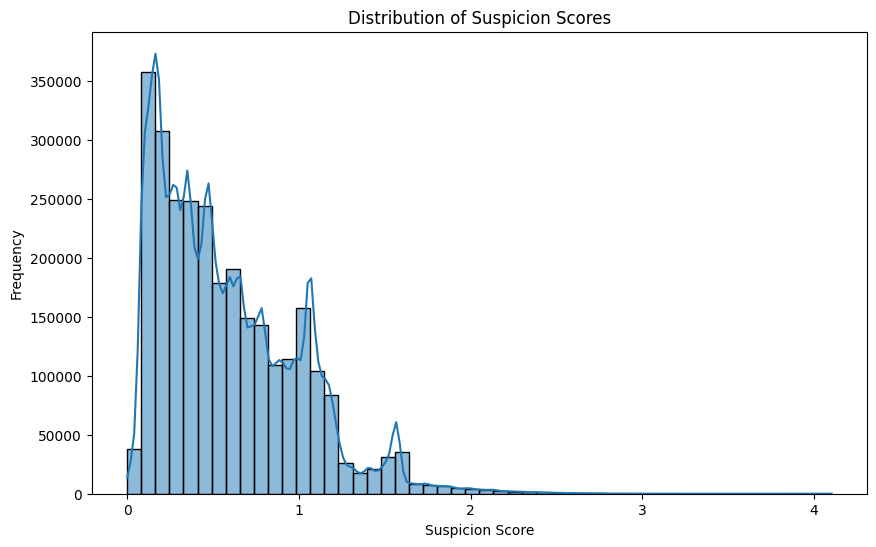

In [ ]:
# Plot the distribution of suspicion scores
plt.figure(figsize=(10, 6))
sns.histplot(transactions['suspicion_score'], bins=50, kde=True)
plt.title('Distribution of Suspicion Scores')
plt.xlabel('Suspicion Score')
plt.ylabel('Frequency')
plt.show()


In [25]:
# Calculate percentiles for suspicion scores
high_suspicion_percentile = np.percentile(transactions['suspicion_score'], 95)
medium_suspicion_percentile = np.percentile(transactions['suspicion_score'], 80)

# Add suspicion level to the DataFrame
transactions['suspicion_level'] = 'Low'
transactions.loc[transactions['suspicion_score'] > high_suspicion_percentile, 'suspicion_level'] = 'High'
transactions.loc[(transactions['suspicion_score'] > medium_suspicion_percentile) & (transactions['suspicion_score'] <= high_suspicion_percentile), 'suspicion_level'] = 'Medium'

print("High Suspicion Percentile:", high_suspicion_percentile)
print("Medium Suspicion Percentile:", medium_suspicion_percentile)


# Count the number of transactions in each suspicion level
transactions['suspicion_level'].value_counts()


High Suspicion Percentile: 1.339961596945378
Medium Suspicion Percentile: 0.9533939066239822


,count
suspicion_level,
Low,2278227
Medium,427194
High,142360


In [26]:

# Classify transactions based on suspicion scores
def classify_transaction(score):
  if score > high_suspicion_percentile:
    return 'Fraudulent'
  elif score > medium_suspicion_percentile:
    return 'suspecious'
  else:
    return 'normal'

transactions['suspicion_level'] = transactions['suspicion_score'].apply(classify_transaction)


In [27]:
# Count the number of transactions in each suspicion level
transactions['suspicion_level'].value_counts()


,count
suspicion_level,
normal,2278227
suspecious,427194
Fraudulent,142360


In [ ]:
# Group the transactions by cluster and calculate summary statistics
cluster_summary = transactions.groupby('cluster').agg({
    'log_total_deposits': ['mean', 'std'],
    'log_total_withdrawals': ['mean', 'std'],
    'suspicion_score': ['mean', 'std', 'min', 'max']
})

# Print the summary statistics
print(cluster_summary)


        log_total_deposits           log_total_withdrawals            \
                      mean       std                  mean       std   
cluster                                                                
0                 6.404130  2.699078              0.356624  1.147088   
1                 8.857425  2.242898              8.790714  2.262647   
2                 0.598231  1.499970              6.256852  1.890485   

        suspicion_score                                
                   mean       std       min       max  
cluster                                                
0              0.571715  0.419665  0.025551  2.957718  
1              0.673007  0.446060  0.000304  4.102569  
2              0.510141  0.356270  0.006973  3.408330  


In [ ]:
# Count the number of fraudulent, suspicious, and normal transactions in each cluster
cluster_suspicion = transactions.groupby(['cluster', 'suspicion_level'])['suspicion_level'].count().unstack(fill_value=0)

# Print the counts
print(cluster_suspicion)


suspicion_level  Fraudulent  normal  suspecious
cluster                                        
0                     57157  528220       68994
1                     71672  786313      177168
2                     13531  963692      181034


In [ ]:

# Display the classified transactions
transactions[['CUST_CUSTNO', 'DATE_ONLY', 'total_deposits', 'total_withdrawals', 'suspicion_level']]


,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,suspicion_level
0,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-05,1500.00,-300.00,suspecious
1,00001fd6f1d8852373810b5402eb3ae6adbd610d9d3608...,2023-08-10,12717.60,-2063.00,normal
2,00004da252a8699874230b3b45cd8af120225da77aaa91...,2023-08-15,100.00,-100.00,suspecious
3,0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...,2023-08-01,400514.39,-701001.37,Fraudulent
4,0000700d5e830cfa894850d424f1713b9290eb5dfd6be6...,2023-08-02,524.00,-2734.00,normal
...,...,...,...,...,...
2847776,ffffaa126887038ed403e49535cebc14cc4f1c1a28e62c...,2023-08-09,0.00,-150.00,normal
2847777,ffffaa126887038ed403e49535cebc14cc4f1c1a28e62c...,2023-08-10,0.00,-2070.00,normal
2847778,ffffaa126887038ed403e49535cebc14cc4f1c1a28e62c...,2023-08-18,0.00,-160.00,normal
2847779,ffffaa126887038ed403e49535cebc14cc4f1c1a28e62c...,2023-08-19,0.00,-100.00,normal


In [28]:
# Apply Rule 15 conditions
rule_15_anomalies = transactions[
    (transactions['total_deposits'] >= 6000000) &
    (transactions['total_withdrawals'].abs() >= 0.95 * transactions['total_deposits'])
]
rule_15_anomalies

,CUST_CUSTNO,DATE_ONLY,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,cluster,suspicion_score,suspicion_level
1760,003e0235aab29e1788ce064113f24f8703921030065318...,2023-08-07,1.123600e+07,-1.249790e+07,16.234634,16.341072,1,2.619909,Fraudulent
2440,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-03,7.162326e+06,-7.162163e+06,15.784346,15.784323,1,2.437232,Fraudulent
2442,00527a90ea8ac7e0cb02edb41f08ec69cacd447c1e06a3...,2023-08-07,6.172232e+06,-6.342641e+06,15.635571,15.662806,1,2.389611,Fraudulent
3377,00769b898390fffb9f011f3a58f8758f11737956f1f813...,2023-08-11,1.818689e+08,-1.741000e+08,19.018797,18.975140,1,3.584416,Fraudulent
3380,00769b898390fffb9f011f3a58f8758f11737956f1f813...,2023-08-15,9.200000e+06,-9.048000e+06,16.034714,16.018054,1,2.523334,Fraudulent
...,...,...,...,...,...,...,...,...,...
1853790,ff8d7492d6aa39bc6177141f150c866919549060c062e2...,2023-08-17,1.524500e+07,-1.528450e+07,16.539762,16.542350,1,2.707764,Fraudulent
1853791,ff8d7492d6aa39bc6177141f150c866919549060c062e2...,2023-08-18,1.508358e+07,-1.509133e+07,16.529117,16.529631,1,2.703537,Fraudulent
1854265,ff9f2b5ccdfe4e76cb65ea25e5a9819004960b989c40d9...,2023-08-03,8.211287e+06,-8.230509e+06,15.921020,15.923359,1,2.486563,Fraudulent
1854613,ffabda738508e4c6a75e696549413207707ac1366d57a8...,2023-08-11,6.474800e+06,-6.316800e+06,15.683428,15.658723,1,2.396142,Fraudulent


In [ ]:
# Count Rule 15 anomalies classified as fraudulent
rule_15_fraudulent_count = rule_15_anomalies[rule_15_anomalies['suspicion_level'] == 'Fraudulent'].shape[0]

# Print the count
print(f"Number of Rule 15 anomalies classified as fraudulent: {rule_15_fraudulent_count}")


Number of Rule 15 anomalies classified as fraudulent: 2618


In [ ]:
# Find clusters containing Rule 15 anomalies
rule_15_clusters = rule_15_anomalies['cluster'].unique()
print("Clusters containing Rule 15 anomalies:", rule_15_clusters)


Clusters containing Rule 15 anomalies: [1]


In [ ]:
Total_Anomalies = 2618  # Replace with the actual total number of anomalies if known

# Level 1 calculations
TP1 = 2618
FP1 =  248841- TP1
FN1 = Total_Anomalies - TP1

Precision1 = TP1 / (TP1 + FP1)
Recall1 = TP1 / (TP1 + FN1)
Precision1, Recall1

(0.010520774309699768, 1.0)

In [ ]:
Accuracy1 = (TP1 + (len(transactions) - (TP1 + FP1 + FN1))) / len(transactions)
print("Accuracy :", Accuracy1)


Accuracy : 0.9135386464057453


# without putting the threshold

In [ ]:
#Compare clusters with fraud transactions
fraud_cluster_counts = transactions[transactions.index.isin(rule_15_anomalies.index)]['cluster'].value_counts()

# Output the comparison
print(fraud_cluster_counts)

cluster
1    2618
Name: count, dtype: int64
